# Introduction: Integrated Gradients

As described in [Andreas Madsen's distill paper](https://distill.pub/2019/memorization-in-rnns/), the saliency map is computed by measuring the gradient magnitude of the output w.r.t. the input.

$$
\mathrm{connectivity}(t, \tilde{t}) = \left|\left| \frac{\partial y^{\tilde{t}}_{k}}{\partial x^t} \right|\right|_2
$$

Implementation wise this can be done quite easily with `tf.GradientTape`. However, because the gradient can not be take w.r.t. to an `int32` type, which is how the `token_ids` are encoded, an one-hot-encoding should be used instead. HuggingFace Transformers supports this via `inputs_embeds` which is the actual input-word-embedding, thus by computing $\mathbf{x} \mathbf{W}$ in the `tf.GradientTape` scope the gradient w.r.t. $\mathbf{x}$ can be computed.

Other methods include:

- **LIME** → the go-to when there's no gradients avaiable in the model
- **Grad L2 Norm** → only produces absolute salience scores while all other methods produce signed values
- **Grad · Input** →| can suffer from gradient saturation

# Explain HuggingFace Question Answering NLP models

In [131]:
# some functions to process the output of the model
import tensorflow as tf 
import numpy as np

def get_best_start_end_position(start_scores, end_scores):
  answer_start = tf.argmax(start_scores, axis=1).numpy()[0] 
  answer_end = (tf.argmax(end_scores, axis=1) + 1).numpy()[0] 
  return answer_start, answer_end

def get_correct_span_mask(correct_index, token_size):
  span_mask = np.zeros((1, token_size))
  span_mask[0, correct_index] = 1
  span_mask = tf.constant(span_mask, dtype='float32')
  return span_mask

def get_best_start_end_position(start_scores, end_scores):
  answer_start = tf.argmax(start_scores, axis=1).numpy()[0]
  answer_end = (tf.argmax(end_scores, axis=1) + 1).numpy()[0]
  return answer_start, answer_end

In [151]:
question = "Macedonia was under the rule of which country?"
context = """Macedonia was an ancient kingdom on the periphery of Archaic and Classical Greece, 
and later the dominant state of Hellenistic Greece. Home to the ancient 
Macedonians, it originated on the northeastern part of the Greek peninsula. Before the 4th 
century BC, it was a small kingdom outside of the area dominated by the city-states of Athens, 
Sparta and Thebes, and briefly subordinate to Achaemenid Persia."""

In [152]:
from transformers import TFBertForQuestionAnswering, AutoTokenizer

model_id = "deepset/bert-base-cased-squad2"

model = TFBertForQuestionAnswering.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [153]:
# get the embeddings from the bert model
embeddings = model.weights[0]  
vocab_size = embeddings.shape[0] # size of the embeddings 

In [154]:
# tokenize the input 
tokens = tokenizer(question, context, return_tensors="tf")

Next, we want to extract the input_ids and convert it into input embeddings via the following steps:

1. extract the input_ids and convert it into a list 
2. convert the list to a constant tensor using `tf.constant()`, then convert it into one hot representation using `tf.one_hot()`
3. inside gradient tape, `watch` the converted one hot matrix and retrieve the input embeddings using matrix multiplication 

In [155]:
# 1. extract the input_ids and convert it into a list 
input_ids = list(tokens["input_ids"].numpy()[0])

In [156]:
# 2. convert token ids to one hot representation
import tensorflow as tf

input_ids_tensor = tf.constant([input_ids], dtype='int32')
input_ids_tensor_one_hot = tf.one_hot(input_ids_tensor, vocab_size) 

In [157]:
output

TFQuestionAnsweringModelOutput(loss=None, start_logits=<tf.Tensor: shape=(1, 96), dtype=float32, numpy=
array([[-2.0076518 , -7.2045918 , -8.069622  , -7.7893577 , -7.980871  ,
        -8.336908  , -8.129303  , -7.131869  , -7.921716  , -7.6785626 ,
        -8.546684  , -7.1345553 , -7.318195  , -6.227119  , -5.376001  ,
        -4.908201  , -7.42923   , -7.742961  , -7.8658943 , -8.783863  ,
        -3.3649712 , -8.787881  , -8.989851  , -7.334619  , -2.6127746 ,
        -9.216145  , -8.086845  , -7.4075027 , -6.8931346 , -5.859434  ,
        -7.1022577 , -8.051302  ,  0.51105833, -7.455417  , -7.7751765 ,
        -0.17301428, -8.166928  , -6.0959272 , -8.905188  , -7.722022  ,
        -5.8804617 , -5.4716573 , -7.5173235 , -8.865102  , -5.837375  ,
        -8.01873   , -8.385605  , -7.942085  , -8.2754135 , -8.975491  ,
        -8.953882  , -8.434634  , -5.7408752 , -9.146666  , -8.742657  ,
        -6.445135  , -7.594307  , -6.845506  , -8.900715  , -9.109984  ,
        -9.166708  ,

In [158]:
with tf.GradientTape(watch_accessed_variables=False) as tape:
  # 1. watch input variable
  tape.watch(input_ids_tensor_one_hot)
  
  # multiply input model embedding matrix; allows us do backprop wrt one hot input 
  input_embeds = tf.matmul(input_ids_tensor_one_hot, embeddings)
  
  # 2. get prediction 
  output = model({
    "inputs_embeds": input_embeds,
    "token_type_ids": tokens["token_type_ids"],
    "attention_mask": tokens["attention_mask"]
  })
  start_scores = output.start_logits
  end_scores = output.end_logits
  
  print(f"1. start_scores size: {start_scores.shape}, end_scores: {end_scores.shape}")
  
  answer_start, answer_end = get_best_start_end_position(start_scores, end_scores)
  
  print(f"2. answer_start size: {answer_start.shape}, answer_end size: {answer_end.shape}")
  print(f"\t2a. answer_start: {answer_start}, answer_end: {answer_end}")
  
  start_output_mask = get_correct_span_mask(answer_start, len(input_ids))
  end_output_mask = get_correct_span_mask(answer_end, len(input_ids))
  
  print(f"3. start_output_mask size: {start_output_mask.shape}, end_output_mask size: {end_output_mask.shape}")
  # print(f"\t3a. start_output_mask: {start_output_mask}, end_output_mask: {end_output_mask}")
  
  # zero out all predictions outside of the correct span positions; we want to get gradients wrt to just these positions
  predict_correct_start_token = tf.reduce_sum(start_scores * start_output_mask)
  predict_correct_end_token = tf.reduce_sum(end_scores * end_output_mask) 
  
  print(f"4. predict_correct_start_token size: {predict_correct_start_token.shape}, predict_correct_end_token size: {predict_correct_end_token.shape}")
  print(f"\t4a. predict_correct_start_token: {predict_correct_start_token}, predict_correct_end_token: {predict_correct_end_token}")

  print(f"5. input_ids_tensor_one_hot size: {input_ids_tensor_one_hot.shape}")
  # 3. get gradient of input with respect to both start and end output
  gradient_non_normalized = tf.norm(
    tape.gradient([predict_correct_start_token, predict_correct_end_token], input_ids_tensor_one_hot),axis=2
  )
  print(f"6. gradient_non_normalized size: {gradient_non_normalized.shape}")
  
  # 4. normalize gradient scores and return them as "explanations"
  gradient_tensor = (
      gradient_non_normalized /
      tf.reduce_max(gradient_non_normalized)
  )
  gradients = gradient_tensor[0].numpy().tolist()
  
  token_words = tokenizer.convert_ids_to_tokens(input_ids) 
  token_types = list(tokens["token_type_ids"].numpy()[0])
  answer_text = tokenizer.decode(input_ids[answer_start:answer_end])

1. start_scores size: (1, 93), end_scores: (1, 93)
2. answer_start size: (), answer_end size: ()
	2a. answer_start: 32, answer_end: 36
3. start_output_mask size: (1, 93), end_output_mask size: (1, 93)
4. predict_correct_start_token size: (), predict_correct_end_token size: ()
	4a. predict_correct_start_token: 1.3341236114501953, predict_correct_end_token: -4.106697082519531
5. input_ids_tensor_one_hot size: (1, 93, 28996)
6. gradient_non_normalized size: (1, 93)


In [159]:
answer_text

'Hellenistic Greece'

In [109]:
def clean_tokens(gradients, tokens, token_types):
  """
  Clean the tokens and gradients gradients
  Remove "[CLS]","[CLR]", "[SEP]" tokens
  Reduce (mean) gradients values for tokens that are split ##
  """
  token_holder = []
  token_type_holder = []
  gradient_holder = []
  i = 0
  while i < len(tokens):

    if (tokens[i] not in ["[CLS]","[CLR]", "[SEP]"]):
      token = tokens[i]
      conn = gradients[i]
      token_type = token_types[i]
      if i < len(tokens)-1 :
        if tokens[i+1][0:2] == "##":
          token = tokens[i]
          conn = gradients[i]
          j = 1
          while i < len(tokens)-1 and tokens[i+1][0:2] == "##":
            i +=1
            token += tokens[i][2:]
            conn += gradients[i]
            j+=1
          conn = conn /j
      token_holder.append(token)
      token_type_holder.append(token_type)
      gradient_holder.append(conn)
    i +=1
  return  gradient_holder,token_holder, token_type_holder

In [110]:
gradients, token_words, token_types = clean_tokens(gradients, token_words, token_types)

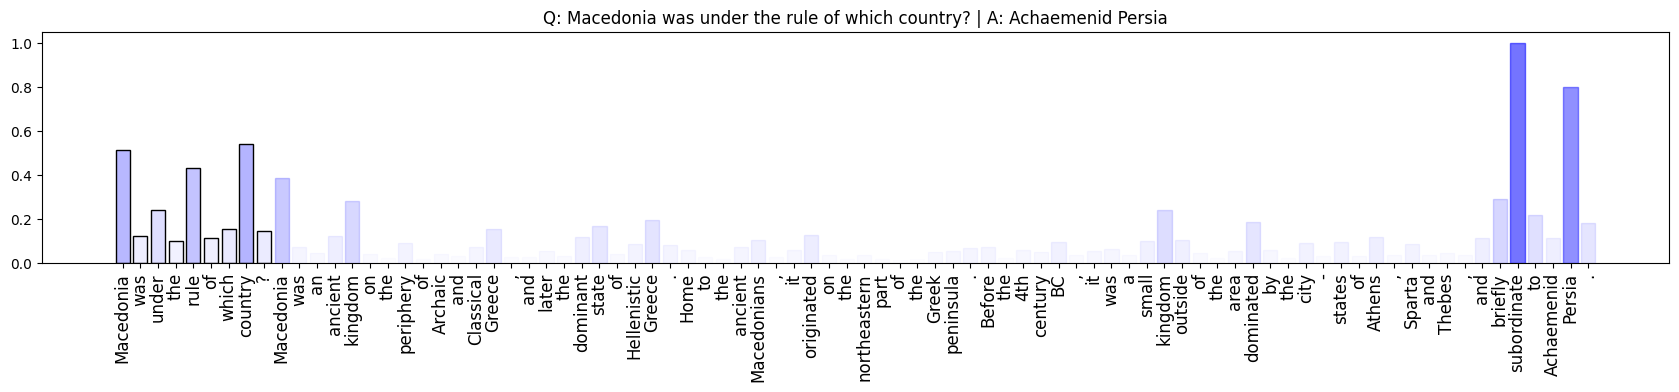

In [ ]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

title = "Q: " + question + " | A: "+ answer_text
grad_norm = normalize([gradients])[0]

plt.figure(figsize=(21,3))
xvals = [ x + str(i) for i,x in enumerate(token_words) ]
colors =  [ (0,0,1, g) for g in grad_norm ]
edgecolors = [ "black" if t==0 else (0,0,1,g)  for g,t in zip(grad_norm, token_types) ]
plt.tick_params(axis='both', which='minor', labelsize=29)

p = plt.bar(xvals, gradients, color=colors, linewidth=1, edgecolor=edgecolors)
plt.title(title)
p=plt.xticks(ticks=[i for i in range(len(token_words))], labels=token_words, fontsize=12,rotation=90)

# Explain HuggingFace NLP classification models 

In [1]:
import numpy as np
import tensorflow as tf

In [2]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

model_id = "mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis"

model = TFAutoModelForSequenceClassification.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)

# model card: https://huggingface.co/mrm8488/distilroberta-finetuned-financial-news-sentiment-analysis

2024-05-13 08:50:35.608872: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-05-13 08:50:35.608893: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-13 08:50:35.608896: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-13 08:50:35.609066: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-13 08:50:35.609277: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you a

In [58]:
text = """
The international electronic industry company Elcoteq has laid off tens of employees from its Tallinn facility ; contrary to earlier layoffs the company contracted the ranks of its office workers , the daily Postimees reported .
"""

In [59]:
print(f"length of model weights: {len(model.weights)}")

for i in range(len(model.weights)):
  name = model.weights[i].name
  if "word_embeddings" in name:
    print(f"layer no. {i} is word_embeddings")

length of model weights: 105
layer no. 96 is word_embeddings


In [60]:
embeddings = model.weights[96]
vocab_size = embeddings.shape[0]

In [61]:
tokens = tokenizer(text, return_tensors="tf")

In [62]:
id2label = {0: "negative", 1: "neutral", 2: "positive"}

id2label[np.argmax(model(tokens).logits)]

'negative'

In [63]:
# 1. convert to list 
# 2. convert to tf.constant with dtypes="int32"
# 3. convert to one hot representation

input_ids_list = list(tokens["input_ids"][0].numpy())
input_ids_tf = tf.constant([input_ids_list], dtype="int32")

# output size: [len(input_ids_tf), vocab_size]
input_ids_tensor_one_hot = tf.one_hot(indices=input_ids_tf, depth=vocab_size) 

In [67]:
tokens.keys()

dict_keys(['input_ids', 'attention_mask'])

In [68]:
def get_logits_mask(correct_index, token_size):
  logits_mask = np.zeros((1, token_size))
  logits_mask[0, correct_index] = 1
  logits_mask = tf.constant(logits_mask, dtype='float32')
  return logits_mask

In [78]:
with tf.GradientTape(watch_accessed_variables=False) as tape:
  
    # 1. watch input variable 
    tape.watch(input_ids_tensor_one_hot)
    
    # multiply input model embedding matrix
    input_embeds = tf.matmul(input_ids_tensor_one_hot, embeddings)
    
    # 2. get the prediction
    logits = model({
    "inputs_embeds": input_embeds,
    "attention_mask": tokens["attention_mask"]
    }).logitsc   
    
    correct_index = tf.argmax(logits, axis=1).numpy()[0]
    logits_mask = get_logits_mask(correct_index, 3)
    
    logtis_pred = tf.reduce_sum(logits*logits_mask)
    
    gradient_non_normalized = tf.norm(
    tape.gradient(logtis_pred, input_ids_tensor_one_hot),axis=2
    )
    
    # 4. normalize gradient scores and return them as "explanations"
    gradient_tensor = (
      gradient_non_normalized /
      tf.reduce_max(gradient_non_normalized)
    )
    
    gradients = gradient_tensor[0].numpy().tolist()

In [71]:
token_words = tokenizer.convert_ids_to_tokens(input_ids_list) 

In [72]:
assert len(gradients) == len(input_ids_list)

In [73]:

def clean_tokens(gradients, tokens):
  """
  Clean the tokens and gradients gradients
  Remove "[CLS]","[CLR]", "[SEP]" tokens
  Reduce (mean) gradients values for tokens that are split ##
  """
  token_holder = []
  gradient_holder = []
    
  i = 0
    
  while i < len(tokens):
    if (tokens[i] not in ["<s>","</s>", "Ċ"]):
      token = tokens[i]
      conn = gradients[i]
      
      if i < len(tokens)-1 :
        if tokens[i+1][0] != "Ġ":
          token = tokens[i]
          conn = gradients[i]
          j = 1
          while (i < len(tokens)-1) and (tokens[i+1][0] != "Ġ") and (tokens[i+1] not in ["<s>","</s>", "Ċ"]):
            i +=1
            token += tokens[i]
            conn += gradients[i]
            j+=1
          conn = conn /j
      if token[0] == "Ġ":
        token_holder.append(token[1:])
      else: 
        token_holder.append(token)  
      gradient_holder.append(conn)
    i +=1
  return  gradient_holder,token_holder

In [76]:
gradients, token_words = clean_tokens(gradients, token_words)

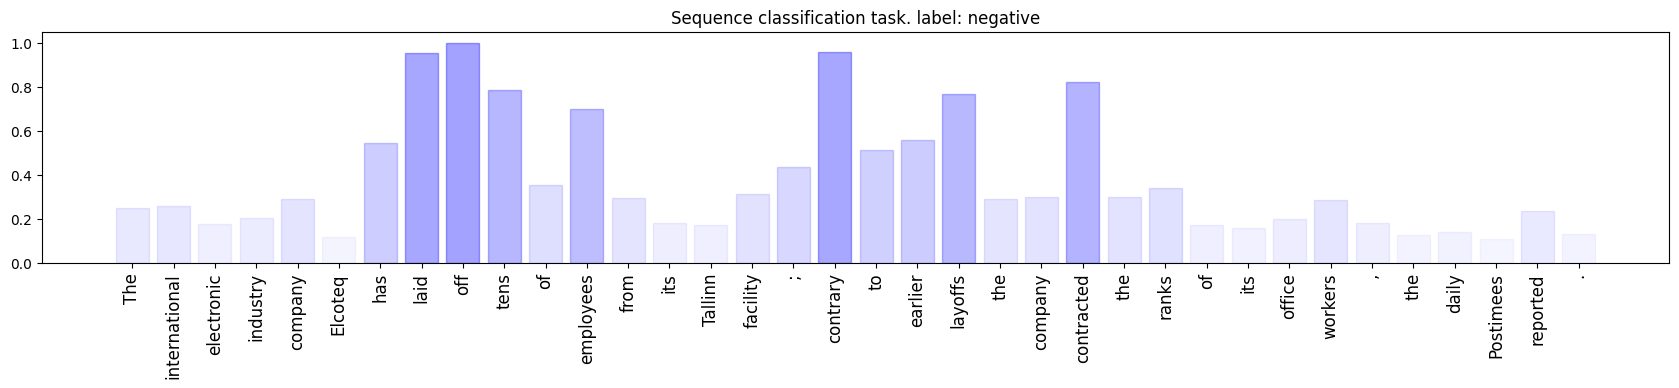

In [77]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

title = f"Sequence classification task. label: {id2label[correct_index]}"
grad_norm = normalize([gradients])[0]

plt.figure(figsize=(21,3))
xvals = [ x + str(i) for i,x in enumerate(token_words) ]
colors =  [ (0,0,1, g) for g in grad_norm ]
# edgecolors = [ "black" if t==0 else (0,0,1,g)  for g,t in zip(grad_norm, token_types) ]
plt.tick_params(axis='both', which='minor', labelsize=29)

p = plt.bar(xvals, gradients, color=colors, linewidth=1, edgecolor=colors)
plt.title(title)
p=plt.xticks(ticks=[i for i in range(len(token_words))], labels=token_words, fontsize=12,rotation=90)

# References

- [How to Explain HuggingFace BERT for Question Answering NLP Models with TF 2.0](https://blog.fastforwardlabs.com/2020/06/22/how-to-explain-huggingface-bert-for-question-answering-nlp-models-with-tf-2.0.html)
- [Gradient Salience: Explaining the output of a HuggingFace BertForQA model](https://colab.research.google.com/drive/1tTiOgJ7xvy3sjfiFC9OozbjAX1ho8WN9?usp=sharing)
- [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)
- [Saliency Maps with HuggingFace and TextualHeatmap](https://colab.research.google.com/github/AndreasMadsen/python-textualheatmap/blob/master/notebooks/huggingface_bert_example.ipynb#scrollTo=X8GJbpoUmYdT)
- [Salience Maps for Text](https://pair-code.github.io/lit/tutorials/text-salience/)